# Observation / Action Specification (Clean Implementation)

TODO:
- [x] Observation Spec `replay_df`
   - [x] Champs
      - [x] Verified
   - [x] Minions
      - [x] Verified
   - [x] Turrets
      - [x] Verified
   - [x] Monsters
      - [x] Verified
   - [x] Missiles
      - [x] Verified
   - [x] Verification (Pre-Scaled)
      - [x] Correct, this is just straight from the SQL statement
   - [x] Verification (Post-Norm)
      - [x] Manual inspection, this is fine, the scaling clearly follows (per-column) the same relative patterns
- [x] Action Spec `replay_df`:
   - [x] Movement
      - [x] Verification
   - [-] Recall (Code available)
   - [x] Spell
     - [x] Q
        - [x] Verify
     - [x] W
        - [x] Verify
     - [x] E (Get direction in digits)
        - [x] Verify
     - [x] D (Flash)
     - [-] F (Ignore this for now)
   - [x] Auto Attack
        - [x] Verify (Looks dodgy asf. Gonna keep for now and hopefully just replace with activespell in future)
- [x] Normalisation and Embedding
   - [x] Normalise numeric values (Min-Max, what type of norm to use here?)
   - [x] Convert strings into embeddings
      - [x] Straight up encode all known string lists
      - [-] Hash open-ended lists (spell name, etc.) and then encode using the hash list
         - [x] Opted for prescence based lists (using idx of present missiles. \
               This should be fine regardless. For the real scale up version of this, \
               will have to use the complete data dragon list regardless.)
- [x] Data Verification

## Populate Game Object Dataframes

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

db_replays_dir = "/Users/joe/Downloads/DB"
db_replays = os.listdir(db_replays_dir)

In [2]:
with open("list_of_champs.txt") as f:
    CHAMP_LIST = f.read().split("\n")

In [3]:
import sqlite3
import pandas as pd
import os
db_replay = os.path.join(db_replays_dir, db_replays[0])
con = sqlite3.connect(db_replay)

In [4]:
SUMMONER_NAMES = ["SummonerBarrier", "SummonerBoost", "SummonerDot", "SummonerExhaust", "SummonerFlash", "SummonerHaste", "SummonerHeal", "SummonerMana", "SummonerTeleport", "SummonerSmite"]
MINION_NAMES = ['SRU_ChaosMinionMelee', 'SRU_OrderMinionMelee',
       'SRU_ChaosMinionRanged', 'SRU_OrderMinionRanged',
       'SRU_Plant_Vision', 'SRU_OrderMinionSiege', 'SRU_ChaosMinionSiege',
       'TestCubeRender']

In [5]:
AUTO_ATTACK_TARGETS = ["CHAMPS", "TURRETS", "MINIONS", "MISSILES", "MONSTERS", "OTHER"]

In [6]:
GAME_OBJECT_LIST = ["champs", "turrets", "minions", "missiles", "monsters"]

In [7]:
MAX_OBJS = [10, 30, 30, 30, 30]

In [8]:
df_s = {
    obj:pd.read_sql(f"SELECT * FROM {obj};", con).drop(labels=["game_id"], axis=1) for obj in GAME_OBJECT_LIST}

In [9]:
for obj in GAME_OBJECT_LIST:
    print(obj, df_s[obj].columns, df_s[obj].columns.shape)

champs Index(['time', 'name', 'hp', 'max_hp', 'mana', 'max_mana', 'armor', 'mr', 'ad',
       'ap', 'level', 'atk_range', 'visible', 'team', 'pos_x', 'pos_z',
       'q_name', 'q_cd', 'w_name', 'w_cd', 'e_name', 'e_cd', 'r_name', 'r_cd',
       'd_name', 'd_cd', 'f_name', 'f_cd'],
      dtype='object') (28,)
turrets Index(['time', 'name', 'hp', 'max_hp', 'mana', 'max_mana', 'armor', 'mr', 'ad',
       'ap', 'level', 'atk_range', 'visible', 'team', 'pos_x', 'pos_z'],
      dtype='object') (16,)
minions Index(['time', 'name', 'hp', 'max_hp', 'mana', 'max_mana', 'armor', 'mr', 'ad',
       'ap', 'level', 'atk_range', 'visible', 'team', 'pos_x', 'pos_z'],
      dtype='object') (16,)
missiles Index(['time', 'name', 'missile_name', 'spell_name', 'src_idx', 'dst_idx',
       'start_pos_x', 'start_pos_z', 'end_pos_x', 'end_pos_z', 'pos_x',
       'pos_z'],
      dtype='object') (12,)
monsters Index(['time', 'name', 'hp', 'max_hp', 'mana', 'max_mana', 'armor', 'mr', 'ad',
       'ap', 'level', 

In [10]:
df_s["champs"]

,time,name,hp,max_hp,mana,max_mana,armor,mr,ad,ap,...,w_name,w_cd,e_name,e_cd,r_name,r_cd,d_name,d_cd,f_name,f_cd
0,1.014682,Akali,570.00000,570.000,200.00000,200.0000,35.000,37.0000,67.4000,0.0,...,AkaliW,-1.014682,AkaliE,-1.014682,AkaliR,-1.014682,SummonerFlash,14.321388,SummonerTeleport,14.321388
1,1.014682,Evelynn,642.00000,642.000,315.00000,315.0000,49.000,32.0000,61.0000,18.0,...,EvelynnW,-1.014682,EvelynnE,-1.014682,EvelynnR,-1.014682,SummonerFlash,14.321388,SummonerSmite,14.321388
2,1.014682,Camille,646.00000,646.000,339.00000,339.0000,35.000,48.0000,73.4000,0.0,...,CamilleW,-1.014682,CamilleE,-1.014682,CamilleR,-1.014682,SummonerFlash,14.321388,SummonerTeleport,14.321388
3,1.014682,Ezreal,600.00000,600.000,375.00000,375.0000,36.000,30.0000,67.4000,0.0,...,EzrealW,-1.014682,EzrealE,-1.014682,EzrealR,-1.014682,SummonerHeal,14.321388,SummonerFlash,14.321388
4,1.014682,Rakan,610.00000,610.000,315.00000,315.0000,54.000,32.0000,62.0000,0.0,...,RakanW,-1.014682,RakanE,-1.014682,RakanR,-1.014682,SummonerDot,14.321388,SummonerFlash,14.321388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6695,179.919720,Gnar,429.40005,699.880,37.50000,100.0000,46.664,30.9360,84.5600,0.0,...,GnarW,-178.919720,GnarE,-178.919720,GnarR,-178.919720,SummonerTeleport,321.221800,SummonerFlash,244.177440
6696,179.919720,Viego,442.35980,630.000,10000.00000,10000.0000,34.000,48.0000,62.4000,0.0,...,ViegoW,-178.919720,ViegoE,-178.919720,ViegoR,-178.919720,SummonerSmite,13.755020,SummonerFlash,184.033580
6697,179.919720,Ryze,199.65353,737.280,327.31903,731.9286,25.024,48.9360,60.1600,9.0,...,RyzeW,-178.919720,RyzeE,-3.846909,RyzeR,-178.919720,SummonerTeleport,-163.919720,SummonerFlash,-163.919720
6698,179.919720,Xayah,887.82500,887.825,359.06335,399.0000,43.195,31.9175,80.5625,0.0,...,XayahW,-178.919720,XayahE,0.258713,XayahR,-178.919720,SummonerFlash,-163.919720,SummonerExhaust,-163.919720


## Dataframe Preprocessing

### Clean `missiles_df`

In [11]:
df_s["missiles"] = df_s["missiles"].drop(labels=["name", "src_idx", "dst_idx"], axis=1)

### Convert Champ Names into Index

In [12]:
df_s["champs"] = df_s["champs"][df_s["champs"]["name"].astype(bool)]

In [13]:
df_s["champs"]["name"].unique()

array(['Akali', 'Evelynn', 'Camille', 'Ezreal', 'Rakan', 'Gnar', 'Viego',
       'Ryze', 'Xayah', 'Thresh'], dtype=object)

In [14]:
df_s["champs"]["name"] = df_s["champs"]["name"].apply(lambda d: CHAMP_LIST.index(d))

/var/folders/zb/zb7f652n559gx4c68jjjxzfh0000gn/T/ipykernel_2327/3781503329.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_s["champs"]["name"] = df_s["champs"]["name"].apply(lambda d: CHAMP_LIST.index(d))


In [15]:
df_s["champs"]["d_name"] = df_s["champs"]["d_name"].apply(lambda d: SUMMONER_NAMES.index(d))
df_s["champs"]["f_name"] = df_s["champs"]["f_name"].apply(lambda d: SUMMONER_NAMES.index(d))

/var/folders/zb/zb7f652n559gx4c68jjjxzfh0000gn/T/ipykernel_2327/3400180166.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_s["champs"]["d_name"] = df_s["champs"]["d_name"].apply(lambda d: SUMMONER_NAMES.index(d))
/var/folders/zb/zb7f652n559gx4c68jjjxzfh0000gn/T/ipykernel_2327/3400180166.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_s["champs"]["f_name"] = df_s["champs"]["f_name"].apply(lambda d: SUMMONER_NAMES.index(d))


### Convert Champ Spells into Index

In [16]:
# Full champ spells list which needs to be feature hashed
SPELL_NAMES = \
    df_s["champs"].q_name.unique().tolist() + \
    df_s["champs"].w_name.unique().tolist() + \
    df_s["champs"].e_name.unique().tolist() + \
    df_s["champs"].r_name.unique().tolist()

df_s["champs"]["q_name"] = df_s["champs"]["q_name"].apply(lambda d: SPELL_NAMES.index(d))
df_s["champs"]["w_name"] = df_s["champs"]["w_name"].apply(lambda d: SPELL_NAMES.index(d))
df_s["champs"]["e_name"] = df_s["champs"]["e_name"].apply(lambda d: SPELL_NAMES.index(d))
df_s["champs"]["r_name"] = df_s["champs"]["r_name"].apply(lambda d: SPELL_NAMES.index(d))

/var/folders/zb/zb7f652n559gx4c68jjjxzfh0000gn/T/ipykernel_2327/3913032197.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_s["champs"]["q_name"] = df_s["champs"]["q_name"].apply(lambda d: SPELL_NAMES.index(d))
/var/folders/zb/zb7f652n559gx4c68jjjxzfh0000gn/T/ipykernel_2327/3913032197.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_s["champs"]["w_name"] = df_s["champs"]["w_name"].apply(lambda d: SPELL_NAMES.index(d))
/var/folders/zb/zb7f652n559gx4c68jjjxzfh0000gn/T/ipykernel_2327/3913032197.py:

### Convert Missile Names and Missile Spell Names into Index

In [17]:
# Full champ spells list which needs to be feature hashed
MISSILE_NAMES = \
    df_s["missiles"].missile_name.unique().tolist()
MISSILE_SPELL_NAMES = df_s["missiles"].spell_name.unique().tolist()

df_s["missiles"]["missile_name"] = df_s["missiles"]["missile_name"].apply(lambda d: MISSILE_NAMES.index(d))
df_s["missiles"]["spell_name"] = df_s["missiles"]["spell_name"].apply(lambda d: MISSILE_SPELL_NAMES.index(d))

### Convert Minion and Turret Names into Index

In [18]:
MINION_NAMES   = list(df_s["minions"].name.unique())
TURRET_NAMES   = list(df_s["turrets"].name.unique())
MONSTER_NAMES  = list(df_s["monsters"].name.unique())

df_s["minions"]["name"]  = df_s["minions"]["name"].apply(lambda d: MINION_NAMES.index(d))
df_s["turrets"]["name"]  = df_s["turrets"]["name"].apply(lambda d: TURRET_NAMES.index(d))
df_s["monsters"]["name"] = df_s["monsters"]["name"].apply(lambda d: MONSTER_NAMES.index(d))

In [19]:
df_s["missiles"].head()

,time,missile_name,spell_name,start_pos_x,start_pos_z,end_pos_x,end_pos_z,pos_x,pos_z
0,40.420643,0,0,10881.035,3304.213,10332.000,3112.0000,10334.0000,3114.000
1,40.698338,0,0,10881.035,3304.213,10332.000,3112.0000,10334.0000,3114.000
2,84.601630,1,1,7783.628,8220.531,7554.915,7600.0103,7625.2993,7730.157
3,84.874176,1,1,7783.628,8220.531,7554.915,7600.0103,7554.1055,7478.331
4,85.158110,1,1,7783.628,8220.531,7554.915,7600.0103,7554.1055,7478.331


### Data Cleaning for all Game Object Dataframes

In [20]:
for obj in GAME_OBJECT_LIST:
    if obj != "missiles":
        df_s[obj] = df_s[obj].drop_duplicates(
            subset=["time", "name"])
    else:
        df_s[obj] = df_s[obj].drop_duplicates(
            subset=["time", "missile_name"])
    df_s[obj] = df_s[obj][
        df_s[obj]["time"] > 15]

### Data Normalisation for Champs DF

In [21]:
df_s["champs"].loc[df_s["champs"]['q_cd'] < 0, 'q_cd'] = 0
df_s["champs"].loc[df_s["champs"]['w_cd'] < 0, 'w_cd'] = 0
df_s["champs"].loc[df_s["champs"]['e_cd'] < 0, 'e_cd'] = 0
df_s["champs"].loc[df_s["champs"]['r_cd'] < 0, 'r_cd'] = 0
df_s["champs"].loc[df_s["champs"]['d_cd'] < 0, 'd_cd'] = 0
df_s["champs"].loc[df_s["champs"]['f_cd'] < 0, 'f_cd'] = 0

## Data Verification

#### Plot Champs

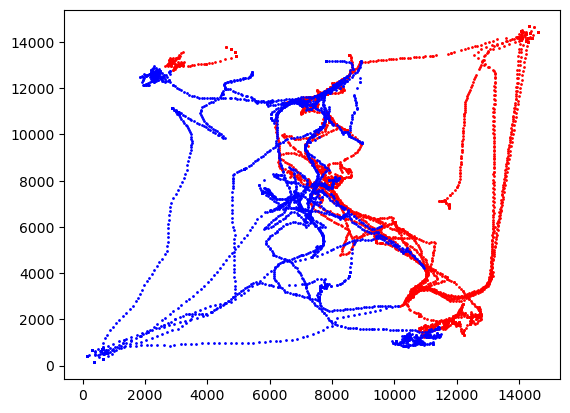

In [143]:
import matplotlib.pyplot as plt
for team in [200, 100]:
    c = "blue" if team == 100 else "red"
    champs_positions_df = pd.read_sql(f"SELECT pos_x, pos_z FROM champs WHERE pos_x < 16000 AND pos_z < 16000 AND team={team};", con)
    champs_positions_x_s = champs_positions_df["pos_x"]
    champs_positions_y_s = champs_positions_df["pos_z"]
    plt.scatter(champs_positions_x_s, champs_positions_y_s, s=1, c=c)

#### Plot Towers

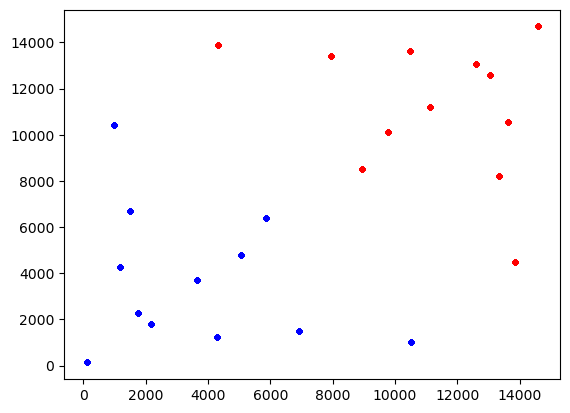

In [144]:
import matplotlib.pyplot as plt
for team in [200, 100]:
    c = "blue" if team == 100 else "red"
    tower_positions_df = pd.read_sql(f"SELECT pos_x, pos_z FROM turrets WHERE pos_x < 16000 AND pos_z < 16000 AND team={team};", con)
    tower_positions_x_s = tower_positions_df["pos_x"]
    tower_positions_y_s = tower_positions_df["pos_z"]
    plt.scatter(tower_positions_x_s, tower_positions_y_s, s=10, c=c)

#### Plot Minions

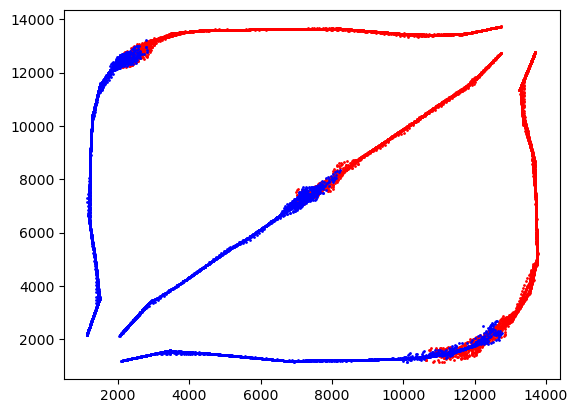

In [139]:
import matplotlib.pyplot as plt
for team in [200, 100]:
    c = "blue" if team == 100 else "red"
    minion_positions_df = pd.read_sql(f"SELECT pos_x, pos_z FROM minions WHERE pos_x < 16000 AND pos_z < 16000 AND team={team};", con)
    minion_positions_df = minion_positions_df.drop_duplicates(subset=["pos_x", "pos_z"])
    minion_positions_x_s = minion_positions_df["pos_x"]
    minion_positions_y_s = minion_positions_df["pos_z"]
    plt.scatter(minion_positions_x_s, minion_positions_y_s, s=1, c=c)

#### Plot Monsters

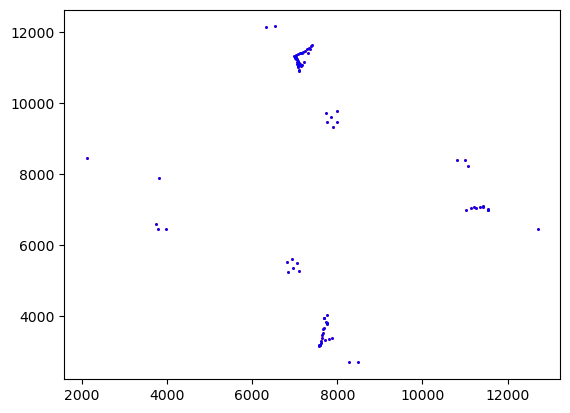

In [146]:
import matplotlib.pyplot as plt
for team in [200, 100]:
    c = "blue" if team == 100 else "red"
    monsters_positions_df = pd.read_sql(f"SELECT pos_x, pos_z FROM monsters WHERE pos_x < 16000 AND pos_z < 16000;", con)
    monsters_positions_df = monsters_positions_df.drop_duplicates(subset=["pos_x", "pos_z"])
    monsters_positions_x_s = monsters_positions_df["pos_x"]
    monsters_positions_y_s = monsters_positions_df["pos_z"]
    plt.scatter(monsters_positions_x_s, monsters_positions_y_s, s=1, c=c)

#### Plot Missiles

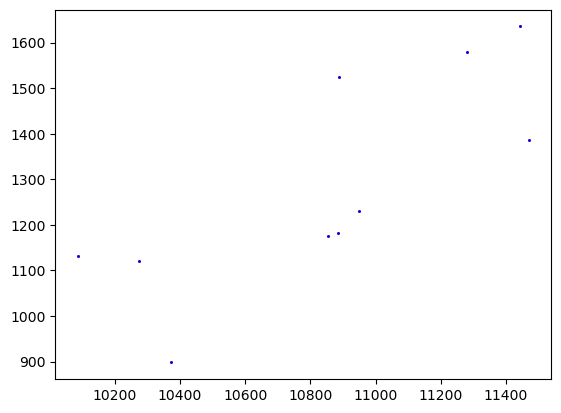

In [157]:
import matplotlib.pyplot as plt
for team in [200, 100]:
    c = "blue" if team == 100 else "red"
    missiles_positions_df = pd.read_sql(f"SELECT pos_x, pos_z FROM missiles WHERE pos_x < 16000 AND pos_z < 16000 AND name LIKE 'EzrealBasic%';", con)
    missiles_positions_df = missiles_positions_df.drop_duplicates(subset=["pos_x", "pos_z"])
    missiles_positions_x_s = missiles_positions_df["pos_x"]
    missiles_positions_y_s = missiles_positions_df["pos_z"]
    plt.scatter(missiles_positions_x_s, missiles_positions_y_s, s=1, c=c)

## Observation Spec

### Init `replay_df`

In [22]:
replay_df = pd.DataFrame()
times = df_s["champs"].drop_duplicates(subset=['time'])["time"]
replay_df["time"] = times

### Add Distance Between Local Player and All Game Objects

In [23]:
player_df = df_s["champs"][df_s["champs"]["name"] == CHAMP_LIST.index("Ezreal")]

In [24]:
def add_distances(original_df):
    # Step 1: Filter out Player's data
    player_df_data = player_df[['time', 'pos_x', 'pos_z']]

    # Step 2: Merge with the original DataFrame on 'time'
    merged_df = original_df.merge(player_df_data, on='time', suffixes=('', '_player'))

    # Step 3: Calculate Euclidean distance
    merged_df['distance_from_player_x'] = abs(
        merged_df["pos_x_player"] - merged_df["pos_x"])
    merged_df['distance_from_player_z'] = abs(
        merged_df["pos_z_player"] - merged_df["pos_z"])
    merged_df['distance_from_player'] = np.sqrt(
        (merged_df['pos_x'] - merged_df['pos_x_player'])**2 +
        (merged_df['pos_z'] - merged_df['pos_z_player'])**2)
    merged_df = merged_df.drop(columns=["pos_x_player", "pos_z_player"])
    
    return merged_df

for obj in GAME_OBJECT_LIST:
    df_s[obj] = add_distances(df_s[obj])

### Min-Max Scale All Non-String Columns

In [25]:
champ_pos    = df_s["champs"].drop_duplicates(subset=["time", "pos_x", "pos_z"])
turrets_pos  = df_s["turrets"].drop_duplicates(subset=["time", "pos_x", "pos_z"])
monsters_pos = df_s["monsters"].drop_duplicates(subset=["time", "pos_x", "pos_z"])
minions_pos  = df_s["minions"].drop_duplicates(subset=["time", "pos_x", "pos_z"])

In [26]:
# Create the scaler instance
champs_scaler   = MinMaxScaler(feature_range=(0, 1))
missiles_scaler = MinMaxScaler(feature_range=(0, 1))
turrets_scaler  = MinMaxScaler(feature_range=(0, 1))
minions_scaler  = MinMaxScaler(feature_range=(0, 1))
monsters_scaler = MinMaxScaler(feature_range=(0, 1))

COLUMNS_TO_SCALE = {
    "champs":   ['time', 'hp', 'max_hp', 'mana', 'max_mana', 'armor', 'mr', 'ad',
       'ap', 'level', 'atk_range', 'visible', 'team', 'pos_x', 'pos_z',
       'q_cd', 'w_cd', 'e_cd', 'r_cd', 'd_cd', 'f_cd', 'distance_from_player_x',
       'distance_from_player_z', 'distance_from_player'],
    "other":  ['time', 'hp', 'max_hp', 'mana', 'max_mana', 'armor', 'mr', 'ad',
       'ap', 'level', 'atk_range', 'visible', 'team', 'pos_x', 'pos_z',
       'distance_from_player_x', 'distance_from_player_z',
       'distance_from_player'],
    "missiles":  ['time', 'start_pos_x', 'start_pos_z',
       'end_pos_x', 'end_pos_z', 'pos_x', 'pos_z', 'distance_from_player_x',
       'distance_from_player_z', 'distance_from_player']
}

for obj in GAME_OBJECT_LIST:
    col_list = obj if obj in COLUMNS_TO_SCALE.keys() else "other"
    cols_to_scale = COLUMNS_TO_SCALE[col_list]  # Columns to be scaled

    # Select columns to scale
    df_to_scale = df_s[obj][cols_to_scale]

    # Determine the appropriate scaler and scale the data
    if obj == "champs":
        scaled_data = champs_scaler.fit_transform(df_to_scale)
    elif obj == "missiles":
        scaled_data = missiles_scaler.fit_transform(df_to_scale)
    elif obj == "turrets":
        scaled_data = turrets_scaler.fit_transform(df_to_scale)
    elif obj == "minions":
        scaled_data = minions_scaler.fit_transform(df_to_scale)
    elif obj == "monsters":
        scaled_data = monsters_scaler.fit_transform(df_to_scale)

    # Replace the original columns in df_s[obj] with the scaled data
    df_s[obj][cols_to_scale] = scaled_data

### Flatten Observations

In [27]:
testdf_s = {}

#### Flatten Each Dataframe

In [28]:
times = df_s["champs"]["time"].unique()

def flatten_obs(df, max_objs, times):
    # print(df.columns)
    new_cols = [f"{c}_{idx}"
                for idx in range(max_objs)
                for c in df.columns[1:]]
    new_cols = ["time"] + new_cols
    obs   = []
    for tm in times:
        cur = df[df["time"] == tm]
        vals = cur.values[:, 1:]
        vals = vals[:max_objs, :]

        if cur.shape[0] < max_objs:
            padding_val = max_objs - vals.shape[0]
            padding = np.zeros((padding_val, vals.shape[1]))
            vals = np.vstack((vals, padding))
    
        # Flatten
        new_vals = np.hstack(vals)

        # Append
        obs.append(new_vals)

    # Combine
    obs   = np.vstack(obs)
    times = np.expand_dims(np.array(times), axis=1)
    obs   = np.hstack((times, obs))
    # print(obs.shape)
    obs_df = pd.DataFrame(data=obs, columns=new_cols)

    return obs_df

for obj, max_objs in zip(GAME_OBJECT_LIST, MAX_OBJS):
    # print("OBJ, MAX:", obj, max_objs)
    testdf_s[obj] = flatten_obs(df_s[obj], max_objs, times)

#### Combine All Flattened Dataframes

In [29]:
times_unsqueeze = np.expand_dims(times, 1)
replay_df_vals = [df.iloc[:, 1:] for df in testdf_s.values()]
replay_df_vals = np.hstack(replay_df_vals)
print(times_unsqueeze.shape, replay_df_vals.shape)
replay_df_vals = np.hstack((times_unsqueeze, replay_df_vals))

(574, 1) (574, 2250)


In [30]:
replay_df_vals.shape

(574, 2251)

In [31]:
def flatten_list(lst):
    return [x for xs in lst for x in xs]

replay_df_cols = [list(testdf_s[k].columns[1:].values) for k in testdf_s.keys()]
replay_df_cols = flatten_list(replay_df_cols)
replay_df_cols = ["time"] + replay_df_cols

In [32]:
replay_df = pd.DataFrame(
    data=replay_df_vals,
    columns=replay_df_cols)
replay_df

,time,name_0,hp_0,max_hp_0,mana_0,max_mana_0,armor_0,mr_0,ad_0,ap_0,...,ap_29,level_29,atk_range_29,visible_29,team_29,pos_x_29,pos_z_29,distance_from_player_x_29,distance_from_player_z_29,distance_from_player_29
0,0.000000,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.001630,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.003313,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.004942,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.006698,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,0.992449,2.0,0.647282,0.634563,0.007828,0.020202,0.461157,0.4238,0.482353,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
570,0.994246,2.0,0.649432,0.634563,0.008403,0.020202,0.461157,0.4238,0.482353,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
571,0.996355,2.0,0.649432,0.634563,0.008403,0.020202,0.461157,0.4238,0.482353,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
572,0.998280,2.0,0.650969,0.634563,0.008978,0.020202,0.461157,0.4238,0.482353,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
replay_df_save_time = replay_df["time"]
replay_df_save_time

0      0.000000
1      0.001630
2      0.003313
3      0.004942
4      0.006698
         ...   
569    0.992449
570    0.994246
571    0.996355
572    0.998280
573    1.000000
Name: time, Length: 574, dtype: float64

## Action Spec

### Temp: Set `replay_df` time to non-scaled times

In [36]:
replay_df["time"] = player_df["time"].values

### Movement

In [83]:
import math

player_cur_pos  = player_df[["time", "pos_x", "pos_z"]]
player_next_pos = player_df[["time", "pos_x", "pos_z"]].shift(+1)
player_next_pos = player_next_pos.fillna(0)
player_x_delta  = player_cur_pos["pos_x"] - player_next_pos["pos_x"]
player_z_delta  = player_cur_pos["pos_z"] - player_next_pos["pos_z"]
player_x_delta.iloc[0] = 0
player_z_delta.iloc[0] = 0

player_x_delta_digit = (player_x_delta / 100).round().clip(-4, +4)
player_z_delta_digit = (player_z_delta / 100).round().clip(-4, +4)

player_df["player_x_delta"]       = player_x_delta
player_df["player_z_delta"]       = player_z_delta
player_df["player_delta"]         = np.sqrt(player_x_delta ** 2 + player_z_delta ** 2)
player_df["player_x_delta_digit"] = player_x_delta_digit
player_df["player_z_delta_digit"] = player_z_delta_digit

In [107]:
player_movement_df_final = \
    player_df[["time", "player_x_delta_digit", "player_z_delta_digit"]] # , "player_x_delta", "player_z_delta", "pos_x", "pos_z"]]
player_movement_df_final

,time,player_x_delta_digit,player_z_delta_digit
503,15.034752,0.0,0.0
513,15.303469,-1.0,-0.0
523,15.581064,-1.0,0.0
533,15.849633,0.0,1.0
543,16.139160,1.0,1.0
...,...,...,...
6643,178.674740,0.0,0.0
6653,178.970980,0.0,0.0
6663,179.318790,0.0,-1.0
6683,179.636140,1.0,1.0


#### Visual Verification (Compare Digitised Movements vs Real Continuous Movements)

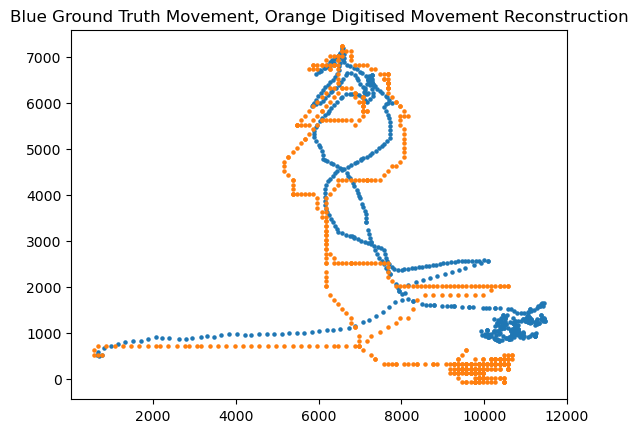

In [108]:
import matplotlib.pyplot as plt

x, y = player_df["pos_x"].iloc[0], player_df["pos_z"].iloc[0]
digit_x_s, digit_z_s = [], []
for cur_x, cur_y in zip(player_movement_df_final["player_x_delta_digit"], player_movement_df_final["player_z_delta_digit"]):
    x += (cur_x) * 100
    y += (cur_y) * 100
    # print(x, y)
    digit_x_s.append(x)
    digit_z_s.append(y)

plt.title("Blue Ground Truth Movement, Orange Digitised Movement Reconstruction")
plt.scatter(player_df["pos_x"], player_df["pos_z"], s=5)
plt.scatter(digit_x_s, digit_z_s, s=5)

In [106]:
replay_df = pd.merge(replay_df, player_movement_df_final, on="time")
replay_df

,time,name_0,hp_0,max_hp_0,mana_0,max_mana_0,armor_0,mr_0,ad_0,ap_0,...,using_e,ezreal_d_x_delta_digit,ezreal_d_z_delta_digit,using_d,player_x_delta_digit_y,player_z_delta_digit_y,player_x_delta,player_z_delta,pos_x,pos_z
0,15.034752,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0,0,0.0,0.0,0.0,0.00000,0.00000,770.00000,530.00000
1,15.303469,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0,0,0.0,-1.0,-0.0,-66.29280,-23.18826,703.70720,506.81174
2,15.581064,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0,0,0.0,-1.0,0.0,-53.77350,11.81979,649.93370,518.63153
3,15.849633,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0,0,0.0,0.0,1.0,29.12227,81.84227,679.05597,600.47380
4,16.139160,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0,0,0.0,1.0,1.0,129.07587,75.99130,808.13184,676.46510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,178.674740,2.0,0.647282,0.634563,0.007828,0.020202,0.461157,0.4238,0.482353,0.0,...,0.0,0,0,0.0,0.0,0.0,49.90700,12.83780,10322.00000,1058.00000
570,178.970980,2.0,0.649432,0.634563,0.008403,0.020202,0.461157,0.4238,0.482353,0.0,...,0.0,0,0,0.0,0.0,0.0,0.00000,0.00000,10322.00000,1058.00000
571,179.318790,2.0,0.649432,0.634563,0.008403,0.020202,0.461157,0.4238,0.482353,0.0,...,0.0,0,0,0.0,0.0,-1.0,35.94900,-72.86450,10357.94900,985.13550
572,179.636140,2.0,0.650969,0.634563,0.008978,0.020202,0.461157,0.4238,0.482353,0.0,...,0.0,0,0,0.0,1.0,1.0,77.15500,142.83310,10435.10400,1127.96860


### Recall (Not Using this Yet)

In [42]:
still_frames_matches = ((player_df["player_x_delta_digit"] == 0) & \
(player_df["player_z_delta_digit"] == 0))
still_frames_idx = still_frames_matches[still_frames_matches].index
still_frames = player_df.loc[still_frames_idx]

still_frames["time_diff"] = still_frames["time"].diff().fillna(0)
still_frames['consecutive'] = still_frames['time_diff'] < 1

still_frames['group'] = (~still_frames['consecutive']).cumsum()

# Get the start and end times for each group
group_start_end_times = still_frames.groupby('group')['time'].agg(['min', 'max'])

# Calculate the duration of each group
group_start_end_times['duration'] = group_start_end_times['max'] - group_start_end_times['min']

# Find groups where the duration is at least 8 seconds
long_groups = group_start_end_times[group_start_end_times['duration'] >= 8].index

# Extract all rows belonging to these groups
long_duration_groups = still_frames[still_frames['group'].isin(long_groups)]
long_duration_groups

,time,name,hp,max_hp,mana,max_mana,armor,mr,ad,ap,...,f_name,f_cd,player_x_delta,player_z_delta,player_delta,player_x_delta_digit,player_z_delta_digit,time_diff,consecutive,group


### Spells

In [43]:
def swap_columns(df, col1, col2):
    """
    Swap two columns in a pandas DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame in which to swap columns.
    col1 (str): The name of the first column to swap.
    col2 (str): The name of the second column to swap.
    """
    temp = df[col1].copy()
    df[col1] = df[col2]
    df[col2] = temp
    return df

In [44]:
d_name = player_df["d_name"]
if d_name.iloc[0] != SUMMONER_NAMES.index("SummonerFlash"):
    swap_columns(player_df, "d_name", "f_name")
    swap_columns(player_df, "d_cd", "f_cd")

In [45]:
d_name = player_df["d_name"]
d_name

503     4
513     4
523     4
533     4
543     4
       ..
6643    4
6653    4
6663    4
6683    4
6693    4
Name: d_name, Length: 574, dtype: int64

In [46]:
spell_casts = player_df[["time", "q_cd", "w_cd", "e_cd", "r_cd", "d_cd", "f_cd"]]

#### Q

In [47]:
# Get every time q was cast (this will be 100% acc)
qcd_s_cur  = spell_casts["q_cd"]
qcd_s_prev = spell_casts["q_cd"].shift(+1).fillna(0)
qcd_s_diff = qcd_s_cur - qcd_s_prev
q_cast     = (qcd_s_diff > 4) & (qcd_s_cur > 0)
# spell_casts_full = spell_casts.merge(q_cast, on=["time"])
print("Number of ezreal q casts:", q_cast.sum())

# Look through ezreal missiles to find the ezreal q's
# (This will be less than 100% acc because of timing issue with scraping
# missiles)
ezreal_q_df = pd.read_sql(
    "SELECT time, start_pos_x, start_pos_z, end_pos_x, end_pos_z FROM missiles WHERE spell_name = 'EzrealQ';",
    con)
ezreal_q_df = ezreal_q_df.drop_duplicates(
    subset=['start_pos_x', 'start_pos_z'])
print(ezreal_q_df)

# Get q spell aim as digital
ezreal_q_start_pos  = ezreal_q_df[["time", "start_pos_x", "start_pos_z"]]
ezreal_q_end_pos = ezreal_q_df[["time", "end_pos_x", "end_pos_z"]]
ezreal_q_end_pos = ezreal_q_end_pos.fillna(0)
ezreal_q_x_delta  = ezreal_q_end_pos["end_pos_x"] - ezreal_q_start_pos["start_pos_x"]
ezreal_q_z_delta  = ezreal_q_end_pos["end_pos_z"] - ezreal_q_start_pos["start_pos_z"]

ezreal_q_x_delta_digit = (ezreal_q_x_delta / 100).round().clip(-4, +4)
ezreal_q_z_delta_digit = (ezreal_q_z_delta / 100).round().clip(-4, +4)

ezreal_q_df["ezreal_q_x_delta"] = ezreal_q_x_delta
ezreal_q_df["ezreal_q_z_delta"] = ezreal_q_z_delta
ezreal_q_df["ezreal_q_x_delta_digit"] = ezreal_q_x_delta_digit
ezreal_q_df["ezreal_q_z_delta_digit"] = ezreal_q_z_delta_digit

Number of ezreal q casts: 9
          time  start_pos_x  start_pos_z  end_pos_x  end_pos_z
0   117.788864    11437.131    1661.6350  12563.790  2071.8050
2   127.895790    10879.960    1182.8914  11011.325  2374.6733
5   138.633450    11398.467    1294.7552  12315.749  2066.8910
8   152.625460    10730.425    1034.5089  11340.131  2066.9136
10  172.179610    10034.534    1048.1306  10985.169  1778.8120
15  178.416630    10251.595     886.4006  11126.689  1706.0410


In [158]:
ezreal_q_df.columns

Index(['time', 'start_pos_x', 'start_pos_z', 'end_pos_x', 'end_pos_z',
       'ezreal_q_x_delta', 'ezreal_q_z_delta', 'ezreal_q_x_delta_digit',
       'ezreal_q_z_delta_digit'],
      dtype='object')

In [177]:
ezreal_q_df_final = \
    ezreal_q_df[["time", "ezreal_q_x_delta_digit", "ezreal_q_z_delta_digit"]]
ezreal_q_df_final["using_q"] = 1
ezreal_q_df_final

/var/folders/zb/zb7f652n559gx4c68jjjxzfh0000gn/T/ipykernel_2327/1335434122.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ezreal_q_df_final["using_q"] = 1


,time,ezreal_q_x_delta_digit,ezreal_q_z_delta_digit,using_q
0,117.788864,4.0,4.0,1
2,127.895790,1.0,4.0,1
5,138.633450,4.0,4.0,1
8,152.625460,4.0,4.0,1
10,172.179610,4.0,4.0,1
15,178.416630,4.0,4.0,1


#### Visual Verification of Ezreal Q's by Comparing Ezreal Position and Missile Lines

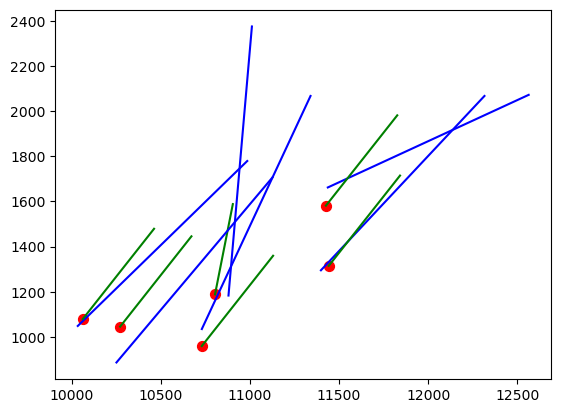

In [180]:
import matplotlib.pyplot as plt

# Assuming you want to plot over the entire range of [0, 16000]
# plt.scatter([0, 16_000], [0, 16_000], s=0)

# Iterate over the rows of the dataframe
for _, row in ezreal_q_df.iterrows():
    tm = row["time"]  # Get the time from the current row
    x  = player_df[player_df["time"] == tm]["pos_x"].iloc[0]  # Use the time to filter the player dataframe
    y  = player_df[player_df["time"] == tm]["pos_z"].iloc[0]  # and get the first matching row
    x1 = row["start_pos_x"]  # Get the starting x position from the current row
    y1 = row["start_pos_z"]  # Get the starting z position from the current row
    x2 = row["end_pos_x"]    # Get the ending x position from the current row
    y2 = row["end_pos_z"]    # Get the ending z position from the current row
    
    digital_x = x
    digital_x += ezreal_q_df_final[ezreal_q_df_final["time"] == tm]["ezreal_q_x_delta_digit"].iloc[0] * 100
    digital_z = y
    digital_z += ezreal_q_df_final[ezreal_q_df_final["time"] == tm]["ezreal_q_z_delta_digit"].iloc[0] * 100
    plt.plot([x1, x2], [y1, y2], color='blue')  # Plot the line for the Ezreal Q
    plt.plot([x, digital_x], [y, digital_z], c="green")
    plt.scatter(x, y, c="red", s=50)  # Plot the player's position

# Set the axes limits if needed
# plt.xlim(0, 16000)
# plt.ylim(0, 16000)

In [49]:
replay_df = pd.merge(replay_df, ezreal_q_df_final, on="time", how="left")

In [50]:
replay_df["using_q"] = replay_df["using_q"].fillna(0)
replay_df = replay_df.fillna(0)
replay_df

,time,name_0,hp_0,max_hp_0,mana_0,max_mana_0,armor_0,mr_0,ad_0,ap_0,...,pos_x_29,pos_z_29,distance_from_player_x_29,distance_from_player_z_29,distance_from_player_29,player_x_delta_digit,player_z_delta_digit,ezreal_q_x_delta_digit,ezreal_q_z_delta_digit,using_q
0,15.034752,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,15.303469,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,15.581064,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,-0.0,0.0,0.0,0.0
3,15.849633,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.0,-1.0,0.0,0.0,0.0
4,16.139160,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,178.674740,2.0,0.647282,0.634563,0.007828,0.020202,0.461157,0.4238,0.482353,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0
570,178.970980,2.0,0.649432,0.634563,0.008403,0.020202,0.461157,0.4238,0.482353,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
571,179.318790,2.0,0.649432,0.634563,0.008403,0.020202,0.461157,0.4238,0.482353,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.0,1.0,0.0,0.0,0.0
572,179.636140,2.0,0.650969,0.634563,0.008978,0.020202,0.461157,0.4238,0.482353,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0


#### W (not verified)

In [51]:
# Get every time w was cast (this will be 100% acc)
wcd_s_cur  = spell_casts["w_cd"]
wcd_s_prev = spell_casts["w_cd"].shift(+1).fillna(0)
wcd_s_diff = wcd_s_cur - wcd_s_prev
w_cast     = (wcd_s_diff > 11) & (wcd_s_cur > 0)
# spell_casts_full = spell_casts.merge(w_cast, on=["time"])
print("Number of ezreal w casts:", w_cast.sum())

# Look through ezreal missiles to find the ezreal w's
# (This will be less than 100% acc because of timing issue with scraping
# missiles)
ezreal_w_df = pd.read_sql(
    "SELECT time, start_pos_x, start_pos_z, end_pos_x, end_pos_z FROM missiles WHERE spell_name = 'EzrealW';",
    con)
ezreal_w_df = ezreal_w_df.drop_duplicates(
    subset=['start_pos_x', 'start_pos_z'])
#ezreal_w_df

# Get w spell aim as digital
ezreal_w_start_pos  = ezreal_w_df[["time", "start_pos_x", "start_pos_z"]]
ezreal_w_end_pos = ezreal_w_df[["time", "end_pos_x", "end_pos_z"]]
ezreal_w_end_pos = ezreal_w_end_pos.fillna(0)
ezreal_w_x_delta  = ezreal_w_end_pos["end_pos_x"] - ezreal_w_start_pos["start_pos_x"]
ezreal_w_z_delta  = ezreal_w_end_pos["end_pos_z"] - ezreal_w_start_pos["start_pos_z"]

ezreal_w_x_delta_digit = (ezreal_w_x_delta / 100).round().clip(-4, +4)
ezreal_w_z_delta_digit = (ezreal_w_z_delta / 100).round().clip(-4, +4)

ezreal_w_df["ezreal_w_x_delta"] = ezreal_w_x_delta
ezreal_w_df["ezreal_w_z_delta"] = ezreal_w_z_delta
ezreal_w_df["ezreal_w_x_delta_digit"] = ezreal_w_x_delta_digit
ezreal_w_df["ezreal_w_z_delta_digit"] = ezreal_w_z_delta_digit

Number of ezreal w casts: 0


In [52]:
ezreal_w_df_final = \
    ezreal_w_df[["time", "ezreal_w_x_delta_digit", "ezreal_w_z_delta_digit"]]
ezreal_w_df_final["using_w"] = 1

In [53]:
replay_df = pd.merge(replay_df, ezreal_w_df_final, on="time", how="left")

In [54]:
replay_df

,time,name_0,hp_0,max_hp_0,mana_0,max_mana_0,armor_0,mr_0,ad_0,ap_0,...,distance_from_player_z_29,distance_from_player_29,player_x_delta_digit,player_z_delta_digit,ezreal_q_x_delta_digit,ezreal_q_z_delta_digit,using_q,ezreal_w_x_delta_digit,ezreal_w_z_delta_digit,using_w
0,15.034752,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1,15.303469,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2,15.581064,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0.0,1.0,-0.0,0.0,0.0,0.0,NaN,NaN,NaN
3,15.849633,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0.0,-0.0,-1.0,0.0,0.0,0.0,NaN,NaN,NaN
4,16.139160,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,178.674740,2.0,0.647282,0.634563,0.007828,0.020202,0.461157,0.4238,0.482353,0.0,...,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,NaN,NaN,NaN
570,178.970980,2.0,0.649432,0.634563,0.008403,0.020202,0.461157,0.4238,0.482353,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
571,179.318790,2.0,0.649432,0.634563,0.008403,0.020202,0.461157,0.4238,0.482353,0.0,...,0.0,0.0,-0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN
572,179.636140,2.0,0.650969,0.634563,0.008978,0.020202,0.461157,0.4238,0.482353,0.0,...,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,NaN,NaN,NaN


In [55]:
replay_df["using_w"] = replay_df["using_w"].fillna(0)
replay_df = replay_df.fillna(0)
replay_df

,time,name_0,hp_0,max_hp_0,mana_0,max_mana_0,armor_0,mr_0,ad_0,ap_0,...,distance_from_player_z_29,distance_from_player_29,player_x_delta_digit,player_z_delta_digit,ezreal_q_x_delta_digit,ezreal_q_z_delta_digit,using_q,ezreal_w_x_delta_digit,ezreal_w_z_delta_digit,using_w
0,15.034752,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0
1,15.303469,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0.0
2,15.581064,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0.0,1.0,-0.0,0.0,0.0,0.0,0,0,0.0
3,15.849633,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0.0,-0.0,-1.0,0.0,0.0,0.0,0,0,0.0
4,16.139160,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,178.674740,2.0,0.647282,0.634563,0.007828,0.020202,0.461157,0.4238,0.482353,0.0,...,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0,0,0.0
570,178.970980,2.0,0.649432,0.634563,0.008403,0.020202,0.461157,0.4238,0.482353,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0
571,179.318790,2.0,0.649432,0.634563,0.008403,0.020202,0.461157,0.4238,0.482353,0.0,...,0.0,0.0,-0.0,1.0,0.0,0.0,0.0,0,0,0.0
572,179.636140,2.0,0.650969,0.634563,0.008978,0.020202,0.461157,0.4238,0.482353,0.0,...,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0,0,0.0


In [56]:
replay_df

,time,name_0,hp_0,max_hp_0,mana_0,max_mana_0,armor_0,mr_0,ad_0,ap_0,...,distance_from_player_z_29,distance_from_player_29,player_x_delta_digit,player_z_delta_digit,ezreal_q_x_delta_digit,ezreal_q_z_delta_digit,using_q,ezreal_w_x_delta_digit,ezreal_w_z_delta_digit,using_w
0,15.034752,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0
1,15.303469,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0.0
2,15.581064,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0.0,1.0,-0.0,0.0,0.0,0.0,0,0,0.0
3,15.849633,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0.0,-0.0,-1.0,0.0,0.0,0.0,0,0,0.0
4,16.139160,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,178.674740,2.0,0.647282,0.634563,0.007828,0.020202,0.461157,0.4238,0.482353,0.0,...,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0,0,0.0
570,178.970980,2.0,0.649432,0.634563,0.008403,0.020202,0.461157,0.4238,0.482353,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0
571,179.318790,2.0,0.649432,0.634563,0.008403,0.020202,0.461157,0.4238,0.482353,0.0,...,0.0,0.0,-0.0,1.0,0.0,0.0,0.0,0,0,0.0
572,179.636140,2.0,0.650969,0.634563,0.008978,0.020202,0.461157,0.4238,0.482353,0.0,...,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0,0,0.0


#### E

In [57]:
# Get every time e was cast (this will be 100% acc)
ecd_s_cur  = spell_casts["e_cd"]
ecd_s_prev = spell_casts["e_cd"].shift(+1).fillna(0)
ecd_s_diff = ecd_s_cur - ecd_s_prev
e_cast     = (ecd_s_diff > 25) & (ecd_s_cur > 0)
print("Number of ezreal e casts:", e_cast.sum())
e_cast_idx_s = e_cast[e_cast].index

# create a dataframe with all of e cast action params
e_cast_vals = []
e_cast_cols = ["time", "ezreal_e_x_delta_digit", "ezreal_e_z_delta_digit"]
for e_cast_idx in e_cast_idx_s:
    # e_cast_idx = e_cast_idx_s[0]
    e_row = player_df.loc[e_cast_idx-50:e_cast_idx+50][["time", "player_delta"]]
    e_row_idx = e_row.idxmax()["player_delta"]
    tm, x, y = player_df.loc[e_row_idx][["time", "player_x_delta_digit", "player_z_delta_digit"]]
    e_cast_vals.append([tm, x, y])

ezreal_e_df_final = pd.DataFrame(data=e_cast_vals, columns=e_cast_cols)
ezreal_e_df_final["using_e"] = 1
ezreal_e_df_final["using_e"] = ezreal_e_df_final["using_e"].fillna(0)
ezreal_e_df_final = ezreal_e_df_final.fillna(0)
ezreal_e_df_final

Number of ezreal e casts: 1


,time,ezreal_e_x_delta_digit,ezreal_e_z_delta_digit,using_e
0,168.84871,4.0,4.0,1


#### Visual Verification of Ezreal E's by Comparing After Ezreal Position vs Digital

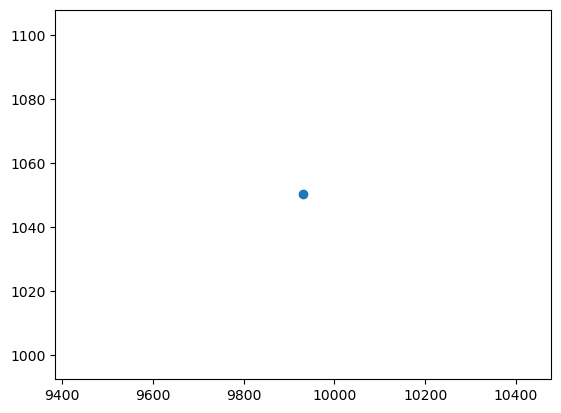

In [184]:
# # x  = player_df[player_df["time"] == tm]["pos_x"].iloc[0]  # Use the time to filter the player dataframe
# tm = ezreal_e_df_final["time"]
# ezreal_x_during_e = player_df[player_df["time"] == tm]["pos_x"].iloc[0]
# ezreal_y_during_e = player_df[player_df["time"] == tm]["pos_z"].iloc[0]
# plt.scatter(ezreal_x_during_e, ezreal_y_during_e)

import matplotlib.pyplot as plt

# Assuming ezreal_e_df_final is a DataFrame with the times you want to plot
for _, row in ezreal_e_df_final.iterrows():
    tm = row["time"]  # Get the current time value from the row
    # Filter player_df for the current time and get the first matching row's position
    ezreal_x_during_e = player_df[player_df["time"] == tm]["pos_x"].iloc[0]
    ezreal_y_during_e = player_df[player_df["time"] == tm]["pos_z"].iloc[0]
    # Plot the position for the current time
    plt.scatter(ezreal_x_during_e, ezreal_y_during_e)

# Show the plot
plt.show()

In [58]:
replay_df = pd.merge(replay_df, ezreal_e_df_final, on="time", how="left")

In [59]:
replay_df

,time,name_0,hp_0,max_hp_0,mana_0,max_mana_0,armor_0,mr_0,ad_0,ap_0,...,player_z_delta_digit,ezreal_q_x_delta_digit,ezreal_q_z_delta_digit,using_q,ezreal_w_x_delta_digit,ezreal_w_z_delta_digit,using_w,ezreal_e_x_delta_digit,ezreal_e_z_delta_digit,using_e
0,15.034752,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,NaN,NaN,NaN
1,15.303469,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,NaN,NaN,NaN
2,15.581064,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,-0.0,0.0,0.0,0.0,0,0,0.0,NaN,NaN,NaN
3,15.849633,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,-1.0,0.0,0.0,0.0,0,0,0.0,NaN,NaN,NaN
4,16.139160,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,-1.0,0.0,0.0,0.0,0,0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,178.674740,2.0,0.647282,0.634563,0.007828,0.020202,0.461157,0.4238,0.482353,0.0,...,-0.0,0.0,0.0,0.0,0,0,0.0,NaN,NaN,NaN
570,178.970980,2.0,0.649432,0.634563,0.008403,0.020202,0.461157,0.4238,0.482353,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,NaN,NaN,NaN
571,179.318790,2.0,0.649432,0.634563,0.008403,0.020202,0.461157,0.4238,0.482353,0.0,...,1.0,0.0,0.0,0.0,0,0,0.0,NaN,NaN,NaN
572,179.636140,2.0,0.650969,0.634563,0.008978,0.020202,0.461157,0.4238,0.482353,0.0,...,-1.0,0.0,0.0,0.0,0,0,0.0,NaN,NaN,NaN


In [60]:
replay_df["using_e"] = replay_df["using_e"].fillna(0)
replay_df = replay_df.fillna(0)
replay_df

,time,name_0,hp_0,max_hp_0,mana_0,max_mana_0,armor_0,mr_0,ad_0,ap_0,...,player_z_delta_digit,ezreal_q_x_delta_digit,ezreal_q_z_delta_digit,using_q,ezreal_w_x_delta_digit,ezreal_w_z_delta_digit,using_w,ezreal_e_x_delta_digit,ezreal_e_z_delta_digit,using_e
0,15.034752,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0
1,15.303469,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0
2,15.581064,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,-0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0
3,15.849633,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,-1.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0
4,16.139160,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,-1.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,178.674740,2.0,0.647282,0.634563,0.007828,0.020202,0.461157,0.4238,0.482353,0.0,...,-0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0
570,178.970980,2.0,0.649432,0.634563,0.008403,0.020202,0.461157,0.4238,0.482353,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0
571,179.318790,2.0,0.649432,0.634563,0.008403,0.020202,0.461157,0.4238,0.482353,0.0,...,1.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0
572,179.636140,2.0,0.650969,0.634563,0.008978,0.020202,0.461157,0.4238,0.482353,0.0,...,-1.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0


#### Flash

In [61]:
# Get every time e was cast (this will be 100% acc)
dcd_s_cur  = spell_casts["d_cd"]
dcd_s_prev = spell_casts["d_cd"].shift(+1).fillna(0)
dcd_s_diff = dcd_s_cur - dcd_s_prev
d_cast     = (dcd_s_diff > 250) & (dcd_s_cur > 0)
d_cast_idx_s = d_cast[d_cast].index

d_cast_vals = []
d_cast_cols = ["time", "ezreal_d_x_delta_digit", "ezreal_d_z_delta_digit"]
for d_cast_idx in d_cast_idx_s:
    d_row = player_df.loc[d_cast_idx-50:d_cast_idx+50][["time", "player_delta"]]
    d_row_idx = d_row.idxmax()["player_delta"]
    tm, x, y = player_df.loc[d_row_idx][["time", "player_x_delta_digit", "player_z_delta_digit"]]
    d_cast_vals.append([tm, x, y])

ezreal_d_df_final = pd.DataFrame(data=d_cast_vals, columns=d_cast_cols)
ezreal_d_df_final["using_d"] = 1
ezreal_d_df_final

,time,ezreal_d_x_delta_digit,ezreal_d_z_delta_digit,using_d


In [62]:
replay_df = pd.merge(replay_df, ezreal_d_df_final, on="time", how="left")

In [63]:
replay_df

,time,name_0,hp_0,max_hp_0,mana_0,max_mana_0,armor_0,mr_0,ad_0,ap_0,...,using_q,ezreal_w_x_delta_digit,ezreal_w_z_delta_digit,using_w,ezreal_e_x_delta_digit,ezreal_e_z_delta_digit,using_e,ezreal_d_x_delta_digit,ezreal_d_z_delta_digit,using_d
0,15.034752,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1,15.303469,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2,15.581064,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
3,15.849633,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
4,16.139160,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,178.674740,2.0,0.647282,0.634563,0.007828,0.020202,0.461157,0.4238,0.482353,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
570,178.970980,2.0,0.649432,0.634563,0.008403,0.020202,0.461157,0.4238,0.482353,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
571,179.318790,2.0,0.649432,0.634563,0.008403,0.020202,0.461157,0.4238,0.482353,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
572,179.636140,2.0,0.650969,0.634563,0.008978,0.020202,0.461157,0.4238,0.482353,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN


In [64]:
replay_df["using_d"] = replay_df["using_d"].fillna(0)
replay_df = replay_df.fillna(0)
replay_df

,time,name_0,hp_0,max_hp_0,mana_0,max_mana_0,armor_0,mr_0,ad_0,ap_0,...,using_q,ezreal_w_x_delta_digit,ezreal_w_z_delta_digit,using_w,ezreal_e_x_delta_digit,ezreal_e_z_delta_digit,using_e,ezreal_d_x_delta_digit,ezreal_d_z_delta_digit,using_d
0,15.034752,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0
1,15.303469,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0
2,15.581064,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0
3,15.849633,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0
4,16.139160,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,178.674740,2.0,0.647282,0.634563,0.007828,0.020202,0.461157,0.4238,0.482353,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0
570,178.970980,2.0,0.649432,0.634563,0.008403,0.020202,0.461157,0.4238,0.482353,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0
571,179.318790,2.0,0.649432,0.634563,0.008403,0.020202,0.461157,0.4238,0.482353,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0
572,179.636140,2.0,0.650969,0.634563,0.008978,0.020202,0.461157,0.4238,0.482353,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0


#### Alt (Not using this yet)

In [65]:
fcd_s_cur  = spell_casts["f_cd"]
fcd_s_prev = spell_casts["f_cd"].shift(+1).fillna(0)
fcd_s_diff = fcd_s_cur - fcd_s_prev
f_cast     = (fcd_s_diff > 180) & (fcd_s_cur > 0)
f_cast_idx_s = f_cast[f_cast].index
print("Alt sum casts:", f_cast.sum())

Alt sum casts: 0


#### Auto Attack

In [66]:
"""
Determine auto attack target:
1. [x] Get all auto attack missile end positions
2. [x] Get all game object positions
3. [x] Match missile end locations with game object positions (within a tolerance)
4. [ ] Get IDX of target type
"""

# 1. Get all auto attack missile end positions
auto_attacks_df = pd.read_sql("SELECT * FROM missiles WHERE spell_name LIKE 'EzrealBasicAttack%';", con)
auto_attacks_df = auto_attacks_df.drop_duplicates(subset=["start_pos_x", "start_pos_z"])
# print(auto_attacks_df)

# 2. Get all game object positions
df_s["champs"]["time"]   = replay_df_save_time
df_s["turrets"]["time"]  = replay_df_save_time
df_s["monsters"]["time"] = replay_df_save_time
df_s["minions"]["time"]  = replay_df_save_time
champ_pos_df    = champ_pos.drop_duplicates(subset=["pos_x", "pos_z"])
turrets_pos_df  = turrets_pos.drop_duplicates(subset=["pos_x", "pos_z"])
monsters_pos_df = monsters_pos.drop_duplicates(subset=["pos_x", "pos_z"])
minions_pos_df  = minions_pos.drop_duplicates(subset=["pos_x", "pos_z"])

# 3. Match missile end locations with game object positions
def find_aa_target(row):
    target_x, target_z = row["pos_x"], row["pos_z"]
    # For each champ pos, check against missile positions
    for _, aa in auto_attacks_df.iterrows():
        end_pos_x, end_pos_z = aa["end_pos_x"], aa["end_pos_z"]
        if target_x == end_pos_x and target_z == end_pos_z:
            print("FOUND AA TARGET")
            return True
    return False

champ_found_aa    = champ_pos_df.apply(lambda r: find_aa_target(r), axis=1)
turrets_found_aa  = turrets_pos_df.apply(lambda r: find_aa_target(r), axis=1)
monsters_found_aa = monsters_pos_df.apply(lambda r: find_aa_target(r), axis=1)
minions_found_aa  = minions_pos_df.apply(lambda r: find_aa_target(r), axis=1)

print(auto_attacks_df.shape)
champ_found_aa.sum(), turrets_found_aa.sum(), monsters_found_aa.sum(), minions_found_aa.sum()

FOUND AA TARGET
FOUND AA TARGET
FOUND AA TARGET
FOUND AA TARGET
FOUND AA TARGET
(7, 13)


(0, 0, 0, 5)

In [67]:
champ_pos_df

,time,name,hp,max_hp,mana,max_mana,armor,mr,ad,ap,...,e_cd,r_name,r_cd,d_name,d_cd,f_name,f_cd,distance_from_player_x,distance_from_player_z,distance_from_player
0,15.034752,2,570.00000,570.000,200.00000,200.0000,35.000,37.0000,67.4000,0.0,...,0.000000,34,0.0,4,0.965248,8,0.965248,140.000,194.0000,239.240465
1,15.034752,29,642.00000,642.000,315.00000,315.0000,49.000,32.0000,61.0000,18.0,...,0.000000,35,0.0,4,0.965248,9,0.965248,106.000,244.0000,266.030073
2,15.034752,19,746.00000,746.000,339.00000,339.0000,35.000,48.0000,83.4000,0.0,...,0.000000,36,0.0,4,0.965248,8,0.965248,22.000,34.0000,40.496913
3,15.034752,30,700.00000,700.000,375.00000,375.0000,36.000,30.0000,77.4000,0.0,...,0.000000,37,0.0,6,0.965248,4,0.965248,0.000,0.0000,0.000000
4,15.034752,100,660.00000,660.000,315.00000,315.0000,54.000,32.0000,62.0000,7.0,...,0.000000,38,0.0,2,0.965248,4,0.965248,472.000,146.0000,494.064773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,179.919720,100,421.39957,734.280,229.83409,351.0000,57.528,33.4760,64.5200,7.0,...,6.102463,38,0.0,2,114.634720,4,222.498120,940.201,4875.7643,4965.587118
5735,179.919720,37,429.40005,699.880,37.50000,100.0000,46.664,30.9360,84.5600,0.0,...,0.000000,39,0.0,8,321.221800,4,244.177440,7283.955,12402.9683,14383.658196
5737,179.919720,109,199.65353,737.280,327.31903,731.9286,25.024,48.9360,60.1600,9.0,...,0.000000,41,0.0,8,0.000000,4,0.000000,2194.932,7219.7573,7546.033525
5738,179.919720,152,887.82500,887.825,359.06335,399.0000,43.195,31.9175,80.5625,0.0,...,0.258713,42,0.0,4,0.000000,3,0.000000,682.258,404.5527,793.182744


In [68]:
# champ_pos    = df_s["champs"].drop_duplicates(subset=["time", "pos_x", "pos_z"])
# turrets_pos  = df_s["turrets"].drop_duplicates(subset=["time", "pos_x", "pos_z"])
# monsters_pos = df_s["monsters"].drop_duplicates(subset=["time", "pos_x", "pos_z"])
# minions_pos  = df_s["minions"].drop_duplicates(subset=["time", "pos_x", "pos_z"])

In [284]:
import matplotlib.pyplot as plt

AUTO_TARGET_TYPES = ["champ", "turret", "monster", "minion"]

def get_target_idx(row, original_df, target_type):
    """
    For each minion (or any other obj) associated with an auto [row]:
    - Find all of the minions (or other obj) associated with that timestep
    - Find out the relative distance idx for that minion (or other obj) and return it
    """

    # champ/turret/monster/minion for target timestep
    objects_at_timestep = original_df[original_df["time"] == row["time"]]
    objects_at_timestep = original_df.sort_values(by="distance_from_player", ascending=[True])

    # print(objects_at_timestep)

    row_x_y              = row[["pos_x", "pos_z"]]
    objs_at_timestep_pos = objects_at_timestep[["pos_x", "pos_z"]]
    
    # print("row_x_y:", row_x_y.iloc[-1])
    # print("objs_at_timestep_pos:", objs_at_timestep_pos.iloc[-1])
    
    objs_at_timestep_pos = objs_at_timestep_pos.reset_index(drop=True)
    target_idx           = objs_at_timestep_pos[
        (row_x_y["pos_x"] == objs_at_timestep_pos["pos_x"]) & \
        (row_x_y["pos_z"] == objs_at_timestep_pos["pos_z"])].index[0]

    time = row["time"]    
    out = pd.Series(data=[time, target_idx, target_type], index=["time", "target_idx", "target_type"])
    return out

    # print("row_x_y.shape, row_x_y, target_idx:", row_x_y.shape, row_x_y, target_idx, end="\n\n")

# target_idx set here
champ_autos    = champ_pos_df.loc[champ_found_aa[champ_found_aa].index][["time", "pos_x", "pos_z"]]
turrets_autos  = turrets_pos_df.loc[turrets_found_aa[turrets_found_aa].index][["time", "pos_x", "pos_z"]]
monsters_autos = monsters_pos_df.loc[monsters_found_aa[monsters_found_aa].index][["time", "pos_x", "pos_z"]]
minions_autos  = minions_pos_df.loc[minions_found_aa[minions_found_aa].index][["time", "pos_x", "pos_z",]]

champ_target_idxs    = champ_autos.apply(lambda row: get_target_idx(
    row, champ_pos_df, AUTO_TARGET_TYPES.index("champ")), axis=1)
turrets_target_idxs  = turrets_autos.apply(lambda row: get_target_idx(
    row, turrets_pos_df, AUTO_TARGET_TYPES.index("turret")), axis=1)
monsters_target_idxs = monsters_autos.apply(lambda row: get_target_idx(
    row, monsters_pos_df, AUTO_TARGET_TYPES.index("monster")), axis=1)
minions_target_idxs  = minions_autos.apply(lambda row: get_target_idx(
    row, minions_pos_df, AUTO_TARGET_TYPES.index("minion")), axis=1)

all_autos_vals = pd.concat([
    champ_autos.apply(lambda row: get_target_idx(
        row, champ_pos_df, AUTO_TARGET_TYPES.index("champ")), axis=1), #[["time"]],
    turrets_autos.apply(lambda row: get_target_idx(
        row, turrets_pos_df, AUTO_TARGET_TYPES.index("turret")), axis=1), #[["time"]],
    monsters_autos.apply(lambda row: get_target_idx(
        row, monsters_pos_df, AUTO_TARGET_TYPES.index("monster")), axis=1), #[["time"]],
    minions_autos.apply(lambda row: get_target_idx(
        row, minions_pos_df, AUTO_TARGET_TYPES.index("minion")), axis=1) # [["time"]]
])

# print(minions_target_idxs)

# # print("champ_autos:",    champ_autos)
# # print("turrets_autos:",  turrets_autos)
# # print("monsters_autos:", monsters_autos)
# # print("minions_autos:",  minions_autos)

all_autos_cols = ["time", "target_idx", "target_type"]
all_autos_vals = np.vstack((champ_target_idxs, turrets_target_idxs, monsters_target_idxs, minions_target_idxs))
# # print(all_autos_vals[0])
# print("all_autos_vals.shape:", all_autos_vals.shape)
all_autos_df   = pd.DataFrame(data=all_autos_vals, columns=all_autos_cols)
# # all_autos_df["target_type"]   = all_autos_df["target_type"].apply(lambda d: AUTO_TARGET_TYPES.index(d))
all_autos_df["using_auto"] = 1

# all_autos_df

all_autos_df


,time,target_idx,target_type,using_auto
0,152.92659,29.0,3.0,1
1,162.48020,6.0,3.0,1
2,165.97435,18.0,3.0,1
3,170.04250,14.0,3.0,1
4,170.77783,2.0,3.0,1


#### Visual Auto Attack Verification

152.92659 11548.402 1578.0912
162.4802 11307.99 1596.6964
165.97435 11085.911 1589.094
170.0425 10857.082 1177.6383
170.77783 10626.0 1222.0


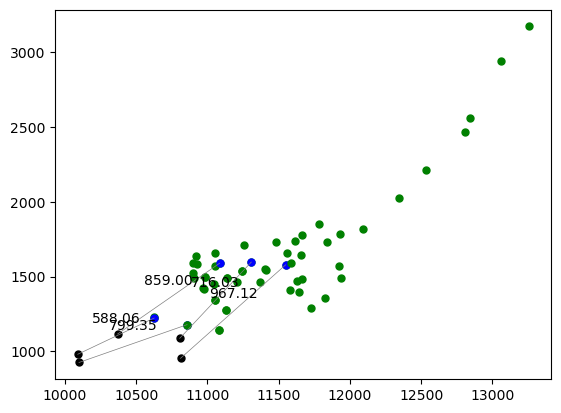

In [285]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have defined the dataframes `minions_autos` and `player_df`
# and that they have a 'time' column which you are using to associate minions with player actions.

# plt.xlim(0, 16000)
# plt.ylim(0, 16000)

minion_auto_times = minions_autos["time"].unique()

minions_df = pd.read_sql("SELECT time, pos_x, pos_z FROM minions WHERE pos_x BETWEEN 10000 AND 14000 AND pos_z BETWEEN 0 AND 4000;", con)

for time in minion_auto_times:
    minions_df_row = minions_df[minions_df["time"] == time]
    minion_auto_row = minions_autos[minions_autos["time"] == time]
    player_row = player_df[player_df["time"] == time]
    
    if not minion_auto_row.empty and not player_row.empty:
        all_minions_x = minions_df_row["pos_x"].values
        all_minions_y = minions_df_row["pos_z"].values
        minions_autos_x = minion_auto_row["pos_x"].values[0]
        minions_autos_y = minion_auto_row["pos_z"].values[0]
        player_x = player_row["pos_x"].values[0]
        player_y = player_row["pos_z"].values[0]
        
        print(time, minions_autos_x, minions_autos_y)

        # Plot minions and players
        plt.scatter(all_minions_x, all_minions_y, c="green", s=25)
        plt.scatter(minions_autos_x, minions_autos_y, c="blue", s=25)
        plt.scatter(player_x, player_y, c="black", s=25)

        # Draw a line between minion and player
        plt.plot([minions_autos_x, player_x], [minions_autos_y, player_y], c="grey", linewidth=0.5)

        # Calculate the distance
        distance = np.sqrt((minions_autos_x - player_x) ** 2 + (minions_autos_y - player_y) ** 2)
        # Annotate the distance on the line
        mid_point = ((minions_autos_x + player_x) / 2, (minions_autos_y + player_y) / 2)
        plt.annotate(f'{distance:.2f}', mid_point, textcoords="offset points", xytext=(0,10), ha='center')

# Show the plot
plt.show()

In [287]:
replay_df = pd.merge(replay_df, all_autos_df, on="time", how="left")

In [288]:
replay_df

,time,name_0,hp_0,max_hp_0,mana_0,max_mana_0,armor_0,mr_0,ad_0,ap_0,...,using_d,player_x_delta_digit_y,player_z_delta_digit_y,player_x_delta,player_z_delta,pos_x,pos_z,target_idx,target_type,using_auto
0,15.034752,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0.0,0.0,0.00000,0.00000,770.00000,530.00000,NaN,NaN,NaN
1,15.303469,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,-1.0,-0.0,-66.29280,-23.18826,703.70720,506.81174,NaN,NaN,NaN
2,15.581064,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,-1.0,0.0,-53.77350,11.81979,649.93370,518.63153,NaN,NaN,NaN
3,15.849633,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0.0,1.0,29.12227,81.84227,679.05597,600.47380,NaN,NaN,NaN
4,16.139160,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,1.0,1.0,129.07587,75.99130,808.13184,676.46510,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,178.674740,2.0,0.647282,0.634563,0.007828,0.020202,0.461157,0.4238,0.482353,0.0,...,0.0,0.0,0.0,49.90700,12.83780,10322.00000,1058.00000,NaN,NaN,NaN
570,178.970980,2.0,0.649432,0.634563,0.008403,0.020202,0.461157,0.4238,0.482353,0.0,...,0.0,0.0,0.0,0.00000,0.00000,10322.00000,1058.00000,NaN,NaN,NaN
571,179.318790,2.0,0.649432,0.634563,0.008403,0.020202,0.461157,0.4238,0.482353,0.0,...,0.0,0.0,-1.0,35.94900,-72.86450,10357.94900,985.13550,NaN,NaN,NaN
572,179.636140,2.0,0.650969,0.634563,0.008978,0.020202,0.461157,0.4238,0.482353,0.0,...,0.0,1.0,1.0,77.15500,142.83310,10435.10400,1127.96860,NaN,NaN,NaN


In [289]:
replay_df["using_auto"] = replay_df["using_auto"].fillna(0)
replay_df = replay_df.fillna(0)
replay_df

,time,name_0,hp_0,max_hp_0,mana_0,max_mana_0,armor_0,mr_0,ad_0,ap_0,...,using_d,player_x_delta_digit_y,player_z_delta_digit_y,player_x_delta,player_z_delta,pos_x,pos_z,target_idx,target_type,using_auto
0,15.034752,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0.0,0.0,0.00000,0.00000,770.00000,530.00000,0.0,0.0,0.0
1,15.303469,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,-1.0,-0.0,-66.29280,-23.18826,703.70720,506.81174,0.0,0.0,0.0
2,15.581064,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,-1.0,0.0,-53.77350,11.81979,649.93370,518.63153,0.0,0.0,0.0
3,15.849633,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,0.0,1.0,29.12227,81.84227,679.05597,600.47380,0.0,0.0,0.0
4,16.139160,2.0,0.642018,0.000000,0.020000,0.010101,0.365909,0.3500,0.399160,0.0,...,0.0,1.0,1.0,129.07587,75.99130,808.13184,676.46510,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,178.674740,2.0,0.647282,0.634563,0.007828,0.020202,0.461157,0.4238,0.482353,0.0,...,0.0,0.0,0.0,49.90700,12.83780,10322.00000,1058.00000,0.0,0.0,0.0
570,178.970980,2.0,0.649432,0.634563,0.008403,0.020202,0.461157,0.4238,0.482353,0.0,...,0.0,0.0,0.0,0.00000,0.00000,10322.00000,1058.00000,0.0,0.0,0.0
571,179.318790,2.0,0.649432,0.634563,0.008403,0.020202,0.461157,0.4238,0.482353,0.0,...,0.0,0.0,-1.0,35.94900,-72.86450,10357.94900,985.13550,0.0,0.0,0.0
572,179.636140,2.0,0.650969,0.634563,0.008978,0.020202,0.461157,0.4238,0.482353,0.0,...,0.0,1.0,1.0,77.15500,142.83310,10435.10400,1127.96860,0.0,0.0,0.0


In [291]:
# Actions
replay_df["time"] = replay_df_save_time
replay_df.iloc[:, -18:-1]

,ezreal_w_x_delta_digit,ezreal_w_z_delta_digit,using_w,ezreal_e_x_delta_digit,ezreal_e_z_delta_digit,using_e,ezreal_d_x_delta_digit,ezreal_d_z_delta_digit,using_d,player_x_delta_digit_y,player_z_delta_digit_y,player_x_delta,player_z_delta,pos_x,pos_z,target_idx,target_type
0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.00000,0.00000,770.00000,530.00000,0.0,0.0
1,0,0,0.0,0.0,0.0,0.0,0,0,0.0,-1.0,-0.0,-66.29280,-23.18826,703.70720,506.81174,0.0,0.0
2,0,0,0.0,0.0,0.0,0.0,0,0,0.0,-1.0,0.0,-53.77350,11.81979,649.93370,518.63153,0.0,0.0
3,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,1.0,29.12227,81.84227,679.05597,600.47380,0.0,0.0
4,0,0,0.0,0.0,0.0,0.0,0,0,0.0,1.0,1.0,129.07587,75.99130,808.13184,676.46510,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,49.90700,12.83780,10322.00000,1058.00000,0.0,0.0
570,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.00000,0.00000,10322.00000,1058.00000,0.0,0.0
571,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,-1.0,35.94900,-72.86450,10357.94900,985.13550,0.0,0.0
572,0,0,0.0,0.0,0.0,0.0,0,0,0.0,1.0,1.0,77.15500,142.83310,10435.10400,1127.96860,0.0,0.0


In [292]:
replay_df["using_auto"].sum()

5.0

In [293]:
replay_df = replay_df.astype(np.float16)

In [294]:
np.save("replay", replay_df)

## Get GameID

In [74]:
game_id = pd.read_sql("SELECT game_id FROM games;", con)
game_id

,game_id
0,2843393945
